<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Decision Trees & Random Forests Exercise

In this exercise we are going to predict the salary of baseball players using various season stats.

The data dictionary is available in [this document (page 8)](../assets/data/data-dictionary.pdf)

In [1]:
import pandas as pd

baseball = pd.read_csv("../assets/data/hitters.csv")
baseball.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


#### 1: time to do some exploratory data analysis!

We will try to predict the `Salary` column.

Again, to make your life easier, choose a subset of columns to explore and use for prediction.

In [2]:
baseball.isnull().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

Some salaries are missing - gotta get rid of them!

In [3]:
baseball = baseball[baseball["Salary"].isnull() == False]

I don't know much about baseball but I know that "home runs" are good, "assists" and "years in baseball" sound like good features, as do "errors".

We'll create a fake category to "bin" salary into low/medium/high and visualise with a pairplot to see if there are groups of low- or high-paid players for different values of these predictors

In [4]:
baseball["Salary"].plot.hist();

We'll use a 20-60-20 rule to separate data into "low-pay", "average-pay" and "high-pay"

In [5]:
import numpy as np

print(np.percentile(baseball["Salary"], 20),
      np.percentile(baseball["Salary"], 80))

155.0 809.0000000000003


We can use the `.cut` function from `pandas` to create bins by salary.

We'll use the cut-off point from above (also need to specify top and bottom borders) - we can also verify that we created a 20-60-20 split.

In [6]:
bins = [0, 155, 810, baseball["Salary"].max()]
baseball["pay_category"] = pd.cut(baseball["Salary"], bins, labels=["low", "average", "high"])
baseball["pay_category"].value_counts() / len(baseball)

average    0.593156
low        0.205323
high       0.201521
Name: pay_category, dtype: float64

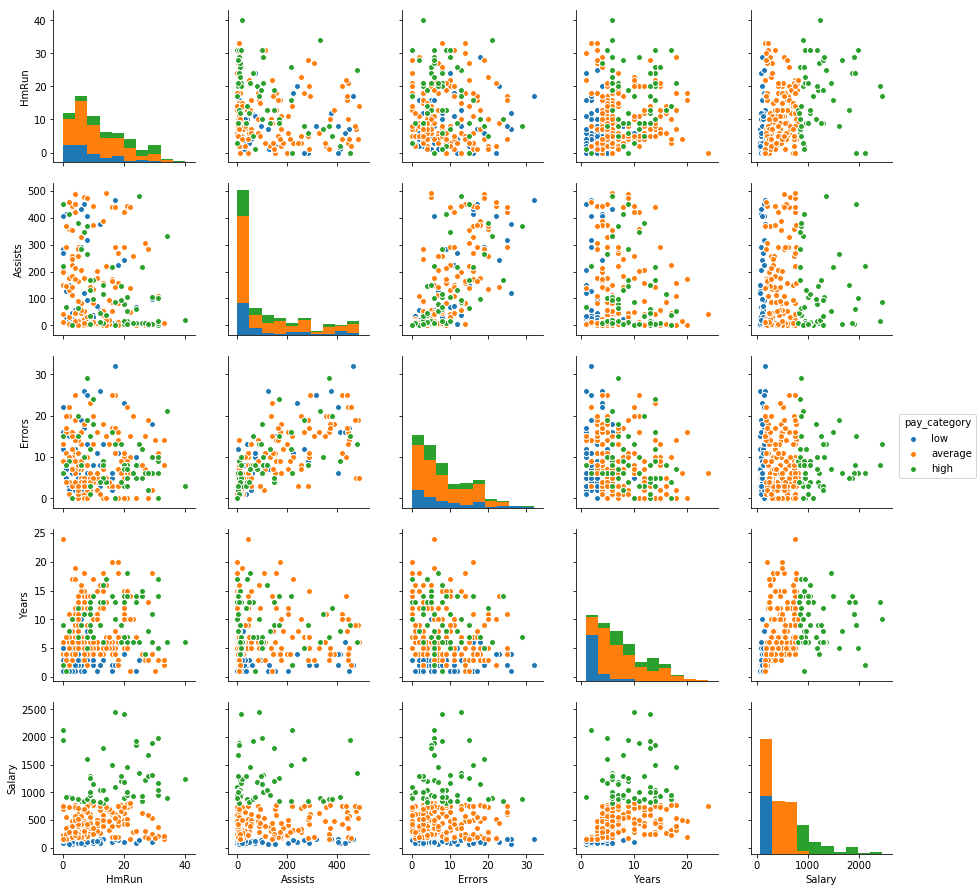

In [7]:
import seaborn as sns
%matplotlib inline

sns.pairplot(data=baseball, vars=["HmRun", "Assists", "Errors", "Years", "Salary"], hue="pay_category");

There seem to be more high-paid players among the veterans so that might be a good feature. The other features are less conclusive. Let's see their relationship to salary:

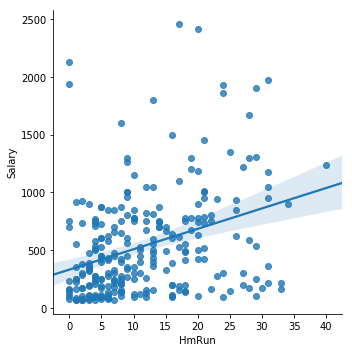

In [8]:
sns.lmplot("HmRun", "Salary", data=baseball);

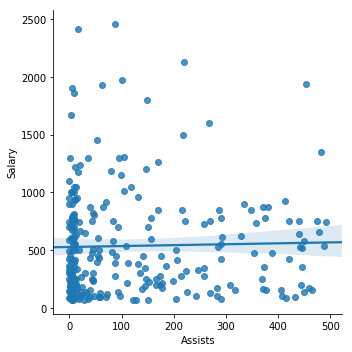

In [9]:
sns.lmplot("Assists", "Salary", data=baseball);

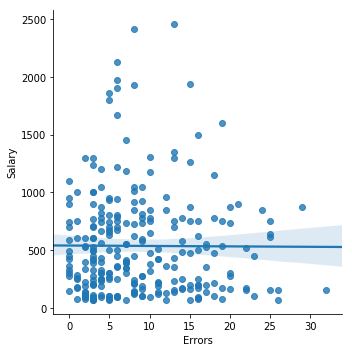

In [10]:
sns.lmplot("Errors", "Salary", data=baseball);

Home runs has a clearer relationship than assists or errors. What about "number of times at bat"?

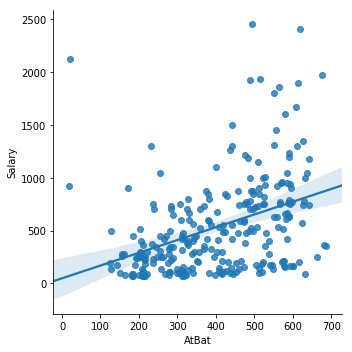

In [11]:
sns.lmplot("AtBat", "Salary", data=baseball);

Let's use all the features, but our assumption is that "errors" and "assists" may not be very predictive.

#### 2: Do a train-test split

In [12]:
baseball.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague', 'pay_category'],
      dtype='object')

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(baseball[["AtBat", "HmRun", "Years", "Assists", "Errors"]],
                                                    baseball["Salary"],
                                                    test_size=0.3,
                                                    random_state=42)

#### 3:  Fit a decision tree and measure its cross-validated performance (using the training set only!)

- Make sure you choose the appropriate kind of tree (classification or regression?)
- Choose an appropriate metric to go with your type of tree

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# this is a regression problem, so use a DecisionTreeRegressor
dt = DecisionTreeRegressor(min_samples_leaf=5)
scores = cross_val_score(dt, X_train, y_train, cv=10, scoring="neg_mean_squared_error")
print("RMSE: ",np.sqrt(np.mean(-scores)))

RMSE:  356.0218697351734


#### 4: Fit a decision tree on the training set limiting its depth to 3-4 levels. Export the `.dot` file and view your tree on [http://www.webgraphviz.com](http://www.webgraphviz.com/)

When you view your tree, what does it tell you? What features are more/less important than others?

In [15]:
from sklearn.tree import export_graphviz

dt = DecisionTreeRegressor(min_samples_leaf=5, max_depth=4)
dt.fit(X_train, y_train)
export_graphviz(dt, "tree.dot", feature_names=X_train.columns)

![](example_tree.png)

From this we can see that `Years` and `AtBat` are important as they're near the top, and `Years` is used at every level.

#### 4: Fit a random forest and compare its cross-validated performance to your decision tree.

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=11, min_samples_leaf=5)
scores = cross_val_score(rf, X_train, y_train, cv=10, scoring="neg_mean_squared_error")
print("RMSE: ",np.sqrt(np.mean(-scores)))

RMSE:  327.76385872082744


365 was the tree's RMSE, and the Random Forest beat it by quite a bit.

#### 5: Look at the random forest's feature importances - how do they compare to the decision tree?

Remember: if you used `cross_val_score` above, you need to fit another random forest!

In [17]:
rf = RandomForestRegressor(n_estimators=11, min_samples_leaf=5)
rf.fit(X_train, y_train)

for z in zip(X_train.columns, rf.feature_importances_):
    print(z)

('AtBat', 0.28699541264407435)
('HmRun', 0.09720007821923908)
('Years', 0.5072878572968968)
('Assists', 0.07933683819359932)
('Errors', 0.029179813646190433)


Both models seem to agree that `Years` and `AtBat` are the most important features.

#### 6: BONUS - try to improve your best model!

- fine-tune some of your hyperparameters using grid search
- some things to tune for a Decision Tree:
    - `max_depth`
    - `min_samples_leaf`
- and for a Random Forest:
    - `max_depth`
    - `min_samples_leaf`
    - `n_estimators`
- also get a final performance measure on your held-out test set!

In [18]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=RandomForestRegressor(),
                    param_grid={"n_estimators": [9, 11, 13, 15, 17, 19, 21],
                                "min_samples_leaf": [5, 10, 25],
                                "max_depth": [3, 7, 10]},
                    scoring="neg_mean_squared_error",
                    cv=5)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [9, 11, 13, 15, 17, 19, 21], 'min_samples_leaf': [5, 10, 25], 'max_depth': [3, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [19]:
grid.best_params_

{'max_depth': 7, 'min_samples_leaf': 5, 'n_estimators': 17}

In [20]:
np.sqrt(-grid.best_score_)

306.7284773712388

That's made a bit of a difference, let's train a Random Forest with those parameters and evaluate on the test set

In [21]:
from sklearn.metrics import mean_squared_error

rf_final = RandomForestRegressor(max_depth=7, min_samples_leaf=10, n_estimators=9)
rf_final.fit(X_train, y_train)
y_pred = rf_final.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

401.4670425500511

Seems like we overfit and an RMSE of 396 isn't great when that's near the median amount!